In [1]:
import rasterio as rio
from rasterio.mask import mask
import os,sys
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
import multiprocessing as mp

from proc_helpers import create_buffer_point_erase_polygon2, \
                         create_buffer_point_erase_polygon, \
                         pixel_flags, pp_summarize_ndvi_with_qa_dir, \
                         summarize_ndvi_with_qa_dir, \
                         create_buffer_point_polygon_overlay, \
                         random_points_within

%matplotlib inline

In [2]:
shpfile = '../testing_villages/Agin_Villages.shp'
df = gpd.read_file(shpfile)
print(df.crs)

{'init': 'epsg:32736'}


(56, 1)


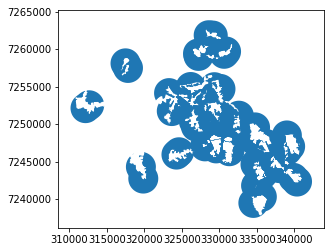

In [3]:
buff_erase_df = create_buffer_point_polygon_overlay(df, method='difference', num_points=2)
buff_erase_df.crs = {'init' :'epsg:32736'}
buff_erase_df.plot()

In [4]:
buff_erase_df.shape


(56, 1)

## get the NDVI and pixel_qa raster paths and check that they match up

In [7]:
from glob import glob

qa_dir = '../landsat/test/qa/'
qa_files = sorted(glob(qa_dir + '*.tif')) # sorted helps ensure the filenames match

ndvi_dir = '../landsat/test/ndvi/'
ndvi_files = sorted(glob(ndvi_dir + '*.tif')) # sorted helps ensure the filenames match


In [ ]:
raster_pairs = zip(ndvi_files, qa_files)
geom = buff_erase_df.to_crs(epsg = 32636)['geometry'][0]
pair = list(raster_pairs)[0]

In [ ]:
# get arrays... nodata will be -9999
ndvi, qa = pair
with rio.open(ndvi) as src:
    n_arr, _ = mask(src, [geom], crop=True)
    
with rio.open(qa) as src:
    qa_arr, _ = mask(src, [geom], crop=True)
    
# generate values from QA band to mask
mask_vals = []
mask_keys = ('Cloud Shadow', 'Cloud')
for k in mask_keys:
    mask_vals.extend(pixel_flags['pixel_qa']['L8'][k])
    
# set the mask_vals in n_arr to nodata value
n_arr[np.isin(n_arr, mask_vals)] = -9999

# mask the array for computation
ma_n_arr = np.ma.masked_equal(n_arr, -9999)

# calculate something
calc_val = np.median(n_arr[n_arr != -9999]) / 10000
calc_val, np.ma.median(ma_n_arr)/10000 ## check this....no

In [ ]:
from pprint import pprint
pprint(pixel_flags['pixel_qa']['L8'].keys())

In [ ]:
plt.imshow(ma_n_arr[0])


In [ ]:
import time

t0 = time.time()
test_function_pp = pp_summarize_ndvi_with_qa_dir(ndvi_dir, qa_dir, buff_erase_df, 'median')
t1 = time.time()
print('parallel across 6 cores and 28 geometries is: {}'.format(t1-t0))

# t0 = time.time()
# test_function = summarize_ndvi_with_qa_dir(ndvi_dir, qa_dir, buff_erase_df, 'median')
# t1 = time.time()
# print('serial and 28 geometries is: {}'.format(t1-t0))

In [ ]:
test_function_pp.to_crs(epsg=32736).to_file('test_landsat_summaries_1997_2017_median_maskCloudWater.shp')

## test number of points for scaling

In [8]:
import time

times = []
total_points = []
num_points = (1,2,3,4,5,6,7)
for npoints in num_points:
    
    buff_erase_df = create_buffer_point_polygon_overlay(df, method='difference', num_points=npoints)
    buff_erase_df.crs = {'init' :'epsg:32736'}
    
    t0 = time.time()
    test_function_pp = pp_summarize_ndvi_with_qa_dir(ndvi_dir, qa_dir, buff_erase_df, 'median')
    t1 = time.time()
    
    times.append(t1-t0)
    total_points.append(buff_erase_df.shape[0])
    

(28, 1)
epsg_df: 32736, epsg_raster: 32636
epsg_df: {'init': 'epsg:32636', 'no_defs': True}, epsg_raster: 32636


C:\projects\RD\south_africa\jp\proc_helpers.py:432: UserWarning: Warning: converting a masked element to nan.
  


(56, 1)
epsg_df: 32736, epsg_raster: 32636
epsg_df: {'init': 'epsg:32636', 'no_defs': True}, epsg_raster: 32636
(84, 1)
epsg_df: 32736, epsg_raster: 32636
epsg_df: {'init': 'epsg:32636', 'no_defs': True}, epsg_raster: 32636
(112, 1)
epsg_df: 32736, epsg_raster: 32636
epsg_df: {'init': 'epsg:32636', 'no_defs': True}, epsg_raster: 32636
(140, 1)
epsg_df: 32736, epsg_raster: 32636
epsg_df: {'init': 'epsg:32636', 'no_defs': True}, epsg_raster: 32636
(168, 1)
epsg_df: 32736, epsg_raster: 32636
epsg_df: {'init': 'epsg:32636', 'no_defs': True}, epsg_raster: 32636
(196, 1)
epsg_df: 32736, epsg_raster: 32636
epsg_df: {'init': 'epsg:32636', 'no_defs': True}, epsg_raster: 32636


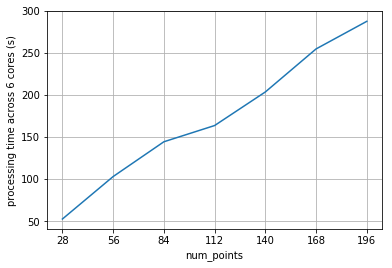

In [18]:
plt.plot(total_points, times)
plt.xlabel("num_points")
plt.ylabel("processing time across 6 cores (s)")

locs, labels = plt.xticks()           # Get locations and labels
plt.xticks(total_points, total_points)  # Set locations and labels

plt.grid(True)
plt.show()

In [15]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(total_points, times)
slope, intercept, r_value, p_value, std_err

(1.3613866336491642,
 20.4609103884016,
 0.9958451860010337,
 2.1323842691077347e-06,
 0.055672903345605596)

In [17]:
bigtime = slope*33000 + intercept
bigtime/60/60

12.485061061336337